This notebook is made to run on colab.<br>
<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages to use colab's GPU
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 15s (28.7 MB/s)
(Reading database ... 155569 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155547 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+

In [2]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import function
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

### In this notebook we are using front view images of 3 different car brands to train a car brand detection model.<br>
The data is scraped from web. There are around 75 images belonging to 3 class. Images are only the front view of the cars.

### To avoid bias due to the dominant color of each car brand, images are turned into grayscale images before feeding them to the model.

In [3]:
# This function turns the pictures into grayscale format with 3 channels.
def to_grayscale_then_rgb(image):
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.grayscale_to_rgb(image)
  return image

### Using the ImageDataGenerator, we define the train and validation sets.
This functions allows us to apply augmentation to the training set as it is loaded into memory and train the model on it. This means we don't need to create new images and save them on our disk.

In [4]:
source = '/content/drive/MyDrive/car_brand_detection/workspace/data'
train_dir = os.path.join(source, 'train')
validation_dir = os.path.join(source, 'validation')

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   width_shift_range=.2,
                                   height_shift_range=.2,
                                   zoom_range=.2,
                                   horizontal_flip=True,
                                   rotation_range=40,
                                   preprocessing_function=to_grayscale_then_rgb,
                                   shear_range=.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(400,400),
                                                    class_mode='categorical',
                                                    batch_size=2)

validation_datagen = ImageDataGenerator(rescale=1./255.)
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(400,400),
                                                              class_mode='categorical',
                                                              batch_size=1)

Found 59 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


### Now let's take a look at the images in the training set

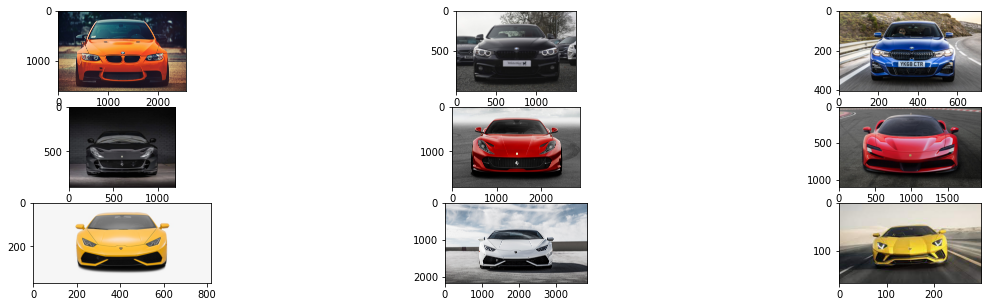

In [5]:
classes = list(train_generator.class_indices.keys())

fig, axis = plt.subplots(3,3, figsize=(20,5))
for row in range(3):
  curr_dir = os.path.join(train_dir, classes[row]) 
  list_dir = os.listdir(curr_dir)
  for col in range(3):
    image = plt.imread(os.path.join(train_dir, classes[row], list_dir[col+5]))
    axis[row, col].imshow(image)
plt.show()

### Now it's time to load our pre-trained model and set the layers to be not trainable. It is a common act in transfer learning to add one or two dense layer with the relavant output shape and trained the model only for those layers.

#### In this notebook we will use the VGG16 model for transfer learning.

In [5]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (400,400,3))
for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                              

### We will add a global average pooling layer and 3 more dense layers to the model to have them trained on the train set.

In [9]:
from tensorflow.keras.models import Model


x = pre_trained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0   

### Now we have to compile the model and have it trained for 50 epochs.

In [10]:
model.compile(optimizer=RMSprop(learning_rate=0.0002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1
)

Epoch 1/50
30/30 [==============================] - 61s 2s/step - loss: 1.2542 - accuracy: 0.3559 - val_loss: 1.0409 - val_accuracy: 0.5333
Epoch 2/50
30/30 [==============================] - 5s 151ms/step - loss: 1.1320 - accuracy: 0.3559 - val_loss: 1.0015 - val_accuracy: 0.4000
Epoch 3/50
30/30 [==============================] - 4s 145ms/step - loss: 1.0792 - accuracy: 0.3559 - val_loss: 1.1301 - val_accuracy: 0.2667
Epoch 4/50
30/30 [==============================] - 5s 149ms/step - loss: 1.0210 - accuracy: 0.4237 - val_loss: 0.9191 - val_accuracy: 0.5333
Epoch 5/50
30/30 [==============================] - 5s 151ms/step - loss: 0.9617 - accuracy: 0.5424 - val_loss: 0.7980 - val_accuracy: 0.6667
Epoch 6/50
30/30 [==============================] - 5s 149ms/step - loss: 0.8663 - accuracy: 0.6441 - val_loss: 0.7706 - val_accuracy: 0.7333
Epoch 7/50
30/30 [==============================] - 5s 154ms/step - loss: 0.8574 - accuracy: 0.5763 - val_loss: 0.7493 - val_accuracy: 0.6667
Epoch 8/

### save the model 

In [12]:
model.save("/content/drive/MyDrive/car_brand_detection/workspace/models/VGG16/car_classification_vgg16_50ep.h5")

### Plot the learning curve

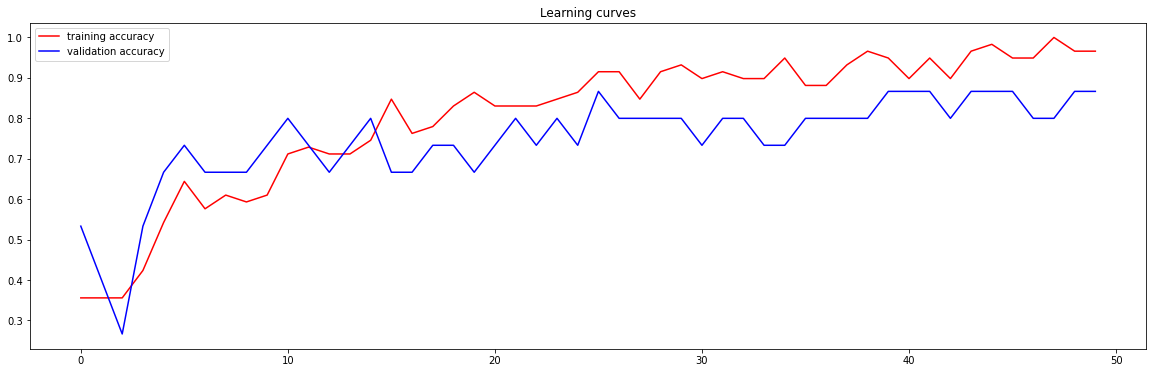

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20,6))
plt.plot(epochs, acc, 'r', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Learning curves')
plt.legend(loc=0)
plt.show()

### Now we load the model to test its performance on our dataset

In [5]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/car_brand_detection/workspace/models/VGG16/car_classification_vgg16_50ep.h5')

In [6]:
validation_generator.class_indices

{'BMW': 0, 'Ferrari': 1, 'Lamborghini': 2}

# Function to return the label map

In [7]:
def label_map(class_indices):
  keys = class_indices.keys()
  values = class_indices.values()
  return dict(zip(values,keys))

### We will iterate through our directories and have our model predict the output

In [16]:
import numpy as np
from keras.preprocessing import image
import os
 
# Label map
map = label_map(validation_generator.class_indices)

for dir in ['train', 'validation']:
  print()
  print('--------------------------------------')
  print(f'Images in the {dir} set:')
  print('--------------------------------------')
  print()
  for label in map.values():
    print()
    print(f'Images of {label}')
    # predicting images
    path = f'/content/drive/MyDrive/car_brand_detection/workspace/data/{dir}/{label}'
    list_dir = os.listdir(path)

    for fn in list_dir:
      img = image.load_img(os.path.join(path,fn), target_size=(400, 400))
      x = image.img_to_array(img)
      x /= 255
      x = np.expand_dims(x, axis=0)

      images = np.vstack([x])
      classes = loaded_model.predict(images, batch_size=10)
      predicted = classes.argmax()
      print('{:>90}  {:>50}'.format(fn[8:], map[predicted]))
      


--------------------------------------
Images in the train set:
--------------------------------------


Images of BMW
                                                                  bmw-m4-f82-720x405px.jpg                                                 BMW
                                                      83d0af2f9234019671ad36076f75ac03.jpg                                                 BMW
                                                        BMW-7-Series-Front-view-164168.jpg                                                 BMW
                                                                       bmw-918408_1280.jpg                                                 BMW
                                                                             104250874.jpg                                                 BMW
                                                      ab43cd941bdec4d9cfeb99a75ce89b45.jpg                                                 BMW
                      